<a href="https://colab.research.google.com/github/gbadeleye/Manufacturing-Projects/blob/main/Multistage_Continuous_Flow_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display

In [2]:
# Load Dataset, parse "time-stamp" column as 1-sec time variable and set as index
df = pd.read_csv('/content/drive/MyDrive/Kaggle/General Forked Projects & Notebooks/Multi-stage continuous-flow manufacturing process.zip (Unzipped Files)/continuous_factory_process.csv',
                 parse_dates=['time_stamp']).set_index('time_stamp').to_period('1S')
df.head()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
time_stamp,,,,,,,,,,,,,,,,,,,,,
2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,48.57,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,48.57,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [3]:
# List columns in dataset
display(df.columns)
#print(df.columns[90:])

Index(['AmbientConditions.AmbientHumidity.U.Actual',
       'AmbientConditions.AmbientTemperature.U.Actual',
       'Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2',
       'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4',
       'Machine1.RawMaterialFeederParameter.U.Actual',
       'Machine1.Zone1Temperature.C.Actual',
       'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual',
       ...
       'Stage2.Output.Measurement10.U.Actual',
       'Stage2.Output.Measurement10.U.Setpoint',
       'Stage2.Output.Measurement11.U.Actual',
       'Stage2.Output.Measurement11.U.Setpoint',
       'Stage2.Output.Measurement12.U.Actual',
       'Stage2.Output.Measurement12.U.Setpoint',
       'Stage2.Output.Measurement13.U.Actual',
       'Stage2.Output.Measurement13.U.Setpoint',
       'Stage2.Output.Measurement14.U.Actual',
       'Stage2.Output.Measurement14.U.Setpoint'],
      dtype='object', length=115)

Columns have lengthy names. Will rename to simpler representations before commencing EDA. Will leverage process control terminologies (e.g. SP, PV, etc) to help simplify renames.

In [4]:
# Rename columns. See dictionary below for proposed names

# Create dictionary for new column names
col_newnames={'AmbientConditions.AmbientHumidity.U.Actual':'Ambient_Humidity',
              'AmbientConditions.AmbientTemperature.U.Actual':'Ambient_Temperature',
              'Machine1.RawMaterial.Property1':'M1_RawMat_Prop1',
              'Machine1.RawMaterial.Property2':'M1_RawMat_Prop2',
              'Machine1.RawMaterial.Property3':'M1_RawMat_Prop3',
              'Machine1.RawMaterial.Property4':'M1_RawMat_Prop4',
              'Machine1.RawMaterialFeederParameter.U.Actual':'M1_RawMat_FdrParam',
              'Machine1.Zone1Temperature.C.Actual':'M1_Zone1_Temp_PV',
              'Machine1.Zone2Temperature.C.Actual':'M1_Zone2_Temp_PV',
              'Machine1.MotorAmperage.U.Actual':'M1_Motor_Amp_PV',
              'Machine1.MotorRPM.C.Actual':'M1_Motor_RPM_PV',
              'Machine1.MaterialPressure.U.Actual':'M1_Matr_Press_PV',
              'Machine1.MaterialTemperature.U.Actual':'M1_Matr_Temp_PV',
              'Machine1.ExitZoneTemperature.C.Actual':'M1_Exit_Temp_PV',
              'Machine2.RawMaterial.Property1':'M2_RawMat_Prop1',
              'Machine2.RawMaterial.Property2':'M2_RawMat_Prop2',
              'Machine2.RawMaterial.Property3':'M2_RawMat_Prop3',
              'Machine2.RawMaterial.Property4':'M2_RawMat_Prop4',
              'Machine2.RawMaterialFeederParameter.U.Actual':'M2_RawMat_FdrParam',
              'Machine2.Zone1Temperature.C.Actual':'M2_Zone1_Temp_PV',
              'Machine2.Zone2Temperature.C.Actual':'M2_Zone2_Temp_PV',
              'Machine2.MotorAmperage.U.Actual':'M2_Motor_Amp_PV',
              'Machine2.MotorRPM.C.Actual':'M2_Motor_RPM_PV',
              'Machine2.MaterialPressure.U.Actual':'M2_Matr_Press_PV',
              'Machine2.MaterialTemperature.U.Actual':'M2_Matr_Temp_PV',
              'Machine2.ExitZoneTemperature.C.Actual':'M2_Exit_Temp_PV',
              'Machine3.RawMaterial.Property1':'M3_RawMat_Prop1',
              'Machine3.RawMaterial.Property2':'M3_RawMat_Prop2',
              'Machine3.RawMaterial.Property3':'M3_RawMat_Prop3',
              'Machine3.RawMaterial.Property4':'M3_RawMat_Prop4',
              'Machine3.RawMaterialFeederParameter.U.Actual':'M3_RawMat_FdrParam',
              'Machine3.Zone1Temperature.C.Actual':'M3_Zone1_Temp_PV',
              'Machine3.Zone2Temperature.C.Actual':'M3_Zone2_Temp_PV',
              'Machine3.MotorAmperage.U.Actual':'M3_Motor_Amp_PV',
              'Machine3.MotorRPM.C.Actual':'M3_Motor_RPM_PV',
              'Machine3.MaterialPressure.U.Actual':'M3_Matr_Press_PV',
              'Machine3.MaterialTemperature.U.Actual':'M3_Matr_Temp_PV',
              'Machine3.ExitZoneTemperature.C.Actual':'M3_Exit_Temp_PV',
              'FirstStage.CombinerOperation.Temperature1.U.Actual':'S1_CombnOp_Temp1_PV',
              'FirstStage.CombinerOperation.Temperature2.U.Actual':'S1_CombnOp_Temp2_PV',
              'FirstStage.CombinerOperation.Temperature3.C.Actual':'S1_CombnOp_Temp3_PV',
              'Stage1.Output.Measurement0.U.Actual':'S1_Out_Meas0_PV',
              'Stage1.Output.Measurement0.U.Setpoint':'S1_Out_Meas0_SP',   
              'Stage1.Output.Measurement1.U.Actual':'S1_Out_Meas1_PV',
              'Stage1.Output.Measurement1.U.Setpoint':'S1_Out_Meas1_SP',  
              'Stage1.Output.Measurement2.U.Actual':'S1_Out_Meas2_PV',
              'Stage1.Output.Measurement2.U.Setpoint':'S1_Out_Meas2_SP', 
              'Stage1.Output.Measurement3.U.Actual':'S1_Out_Meas3_PV',
              'Stage1.Output.Measurement3.U.Setpoint':'S1_Out_Meas3_SP',  
              'Stage1.Output.Measurement4.U.Actual':'S1_Out_Meas4_PV',
              'Stage1.Output.Measurement4.U.Setpoint':'S1_Out_Meas4_SP',
              'Stage1.Output.Measurement5.U.Actual':'S1_Out_Meas5_PV',
              'Stage1.Output.Measurement5.U.Setpoint':'S1_Out_Meas5_SP',
              'Stage1.Output.Measurement6.U.Actual':'S1_Out_Meas6_PV',
              'Stage1.Output.Measurement6.U.Setpoint':'S1_Out_Meas6_SP',
              'Stage1.Output.Measurement7.U.Actual':'S1_Out_Meas7_PV',
              'Stage1.Output.Measurement7.U.Setpoint':'S1_Out_Meas7_SP',
              'Stage1.Output.Measurement8.U.Actual':'S1_Out_Meas8_PV',
              'Stage1.Output.Measurement8.U.Setpoint':'S1_Out_Meas8_SP', 
              'Stage1.Output.Measurement9.U.Actual':'S1_Out_Meas9_PV',
              'Stage1.Output.Measurement9.U.Setpoint':'S1_Out_Meas9_SP',
              'Stage1.Output.Measurement10.U.Actual':'S1_Out_Meas10_PV',
              'Stage1.Output.Measurement10.U.Setpoint':'S1_Out_Meas10_SP',  
              'Stage1.Output.Measurement11.U.Actual':'S1_Out_Meas11_PV',
              'Stage1.Output.Measurement11.U.Setpoint':'S1_Out_Meas11_SP',   
              'Stage1.Output.Measurement12.U.Actual':'S1_Out_Meas12_PV',
              'Stage1.Output.Measurement12.U.Setpoint':'S1_Out_Meas12_SP',  
              'Stage1.Output.Measurement13.U.Actual':'S1_Out_Meas13_PV',
              'Stage1.Output.Measurement13.U.Setpoint':'S1_Out_Meas13_SP',
              'Stage1.Output.Measurement14.U.Actual':'S1_Out_Meas14_PV',
              'Stage1.Output.Measurement14.U.Setpoint':'S1_Out_Meas14_SP',
              'Machine4.Temperature1.C.Actual':'M4_Temp1_PV',
              'Machine4.Temperature2.C.Actual':'M4_Temp2_PV',
              'Machine4.Temperature3.C.Actual':'M4_Temp3_PV',
              'Machine4.Temperature4.C.Actual':'M4_Temp4-PV', 
              'Machine4.Temperature5.C.Actual':'M4_Temp5_PV',
              'Machine4.ExitTemperature.U.Actual':'M4_Exit_Temp_PV',
              'Machine4.Pressure.C.Actual':'M4_Press_PV',
              'Machine5.Temperature1.C.Actual':'M5_Temp1_PV',
              'Machine5.Temperature2.C.Actual':'M5_Temp2_PV', 
              'Machine5.Temperature3.C.Actual':'M5_Temp3_PV',
              'Machine5.Temperature4.C.Actual':'M5_Temp4_PV', 
              'Machine5.Temperature5.C.Actual':'M5_Temp5_PV',
              'Machine5.Temperature6.C.Actual':'M5_Temp6_PV', 
              'Machine5.ExitTemperature.U.Actual':'M5_Exit_Temp_PV',
              'Stage2.Output.Measurement0.U.Actual':'S2_Out_Meas0_PV',
              'Stage2.Output.Measurement0.U.Setpoint':'S2_Out_Meas0_SP',
              'Stage2.Output.Measurement1.U.Actual':'S2_Out_Meas1_PV',
              'Stage2.Output.Measurement1.U.Setpoint':'S2_Out_Meas1_SP',
              'Stage2.Output.Measurement2.U.Actual':'S2_Out_Meas2_PV',
              'Stage2.Output.Measurement2.U.Setpoint':'S2_Out_Meas2_SP',
              'Stage2.Output.Measurement3.U.Actual':'S2_Out_Meas3_PV',
              'Stage2.Output.Measurement3.U.Setpoint':'S2_Out_Meas3_SP',
              'Stage2.Output.Measurement4.U.Actual':'S2_Out_Meas4_PV',
              'Stage2.Output.Measurement4.U.Setpoint':'S2_Out_Meas4_SP',
              'Stage2.Output.Measurement5.U.Actual':'S2_Out_Meas5_PV',
              'Stage2.Output.Measurement5.U.Setpoint':'S2_Out_Meas5_SP',
              'Stage2.Output.Measurement6.U.Actual':'S2_Out_Meas6_PV',
              'Stage2.Output.Measurement6.U.Setpoint':'S2_Out_Meas6_SP',
              'Stage2.Output.Measurement7.U.Actual':'S2_Out_Meas7_PV',
              'Stage2.Output.Measurement7.U.Setpoint':'S2_Out_Meas7_SP',
              'Stage2.Output.Measurement8.U.Actual':'S2_Out_Meas8_PV',
              'Stage2.Output.Measurement8.U.Setpoint':'S2_Out_Meas8_SP',
              'Stage2.Output.Measurement9.U.Actual':'S2_Out_Meas9_PV',
              'Stage2.Output.Measurement9.U.Setpoint':'S2_Out_Meas9_SP',
              'Stage2.Output.Measurement10.U.Actual':'S2_Out_Meas10_PV',
              'Stage2.Output.Measurement10.U.Setpoint':'S2_Out_Meas10_SP',
              'Stage2.Output.Measurement11.U.Actual':'S2_Out_Meas11_PV',
              'Stage2.Output.Measurement11.U.Setpoint':'S2_Out_Meas11_SP',
              'Stage2.Output.Measurement12.U.Actual':'S2_Out_Meas12_PV',
              'Stage2.Output.Measurement12.U.Setpoint':'S2_Out_Meas12_SP',
              'Stage2.Output.Measurement13.U.Actual':'S2_Out_Meas13_PV',
              'Stage2.Output.Measurement13.U.Setpoint':'S2_Out_Meas13_SP',
              'Stage2.Output.Measurement14.U.Actual':'S2_Out_Meas14_PV',
              'Stage2.Output.Measurement14.U.Setpoint':'S2_Out_Meas14_SP'}

# Rename Columns
df=df.rename(columns=col_newnames)

Finally, before commencing EDA, check if dataframe has any bad/missing values. If so, will need to consider how to handle them for further analyses.

In [5]:
# Use isnull() method to check for any missing/bad entry. sum() X 2 sums boolean outputs across both axes
# to count total bad/missing values
df.isnull().sum().sum()

0

No bad/missing value in dataset. Commence EDA.

In [6]:
display(df.describe())
display(df.info())

,Ambient_Humidity,Ambient_Temperature,M1_RawMat_Prop1,M1_RawMat_Prop2,M1_RawMat_Prop3,M1_RawMat_Prop4,M1_RawMat_FdrParam,M1_Zone1_Temp_PV,M1_Zone2_Temp_PV,M1_Motor_Amp_PV,...,S2_Out_Meas10_PV,S2_Out_Meas10_SP,S2_Out_Meas11_PV,S2_Out_Meas11_SP,S2_Out_Meas12_PV,S2_Out_Meas12_SP,S2_Out_Meas13_PV,S2_Out_Meas13_SP,S2_Out_Meas14_PV,S2_Out_Meas14_SP
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,...,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.00,14088.000000,1.408800e+04
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,...,7.535958e+00,7.930000e+00,5.416515e+00,5.650000e+00,1.972561e+00,1.850000e+00,3.535251e+00,2.89,7.515574,1.171000e+01
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,...,1.645785e+00,3.552840e-15,1.182333e+00,8.882099e-16,4.145398e-01,4.441050e-16,4.768244e-01,0.00,2.082948,1.776420e-15
min,13.840000,23.020000,11.540000,200.000000,601.110000,247.000000,231.300000,71.900000,71.300000,44.400000,...,-5.220420e-95,7.930000e+00,-2.703210e-95,5.650000e+00,-6.200020e-96,1.850000e+00,-1.822810e-95,2.89,-3.437021,1.171000e+01
25%,14.040000,23.530000,11.540000,200.000000,963.000000,247.000000,1257.170000,72.000000,71.600000,68.880000,...,7.840000e+00,7.930000e+00,5.560000e+00,5.650000e+00,2.030000e+00,1.850000e+00,3.450000e+00,2.89,7.720000,1.171000e+01
50%,15.120000,23.930000,11.540000,200.000000,963.000000,247.000000,1264.440000,72.000000,72.000000,71.980000,...,7.900000e+00,7.930000e+00,5.630000e+00,5.650000e+00,2.060000e+00,1.850000e+00,3.510000e+00,2.89,7.870000,1.171000e+01
75%,16.630000,24.160000,12.220000,201.000000,1027.430000,251.000000,1273.460000,72.000000,72.400000,72.920000,...,7.950000e+00,7.930000e+00,5.800000e+00,5.650000e+00,2.090000e+00,1.850000e+00,3.760000e+00,2.89,8.080000,1.171000e+01
max,17.240000,24.430000,12.900000,236.000000,1048.060000,257.000000,1331.820000,72.500000,72.700000,88.530000,...,8.590000e+00,7.930000e+00,6.320000e+00,5.650000e+00,5.200000e+00,1.850000e+00,8.000000e+00,2.89,14.260000,1.171000e+01


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14088 entries, 2019-03-06 10:52:33 to 2019-03-06 14:47:20
Freq: S
Columns: 115 entries, Ambient_Humidity to S2_Out_Meas14_SP
dtypes: float64(108), int64(7)
memory usage: 12.5 MB


None

According to info() method, some columns appear to be int64. Suspect these to be the SP variables. Will confirm before continuing 

In [7]:
int_col=[col for col in df.columns if df[col].dtypes=='int64']
display(int_col)

# Good idea to dump the list of SP's before continuing
SP_col=[col for col in df.columns if 'SP' in col]
display(SP_col)

['M1_RawMat_Prop2',
 'M1_RawMat_Prop4',
 'M2_RawMat_Prop2',
 'M2_RawMat_Prop4',
 'M3_RawMat_Prop2',
 'M3_RawMat_Prop4',
 'S2_Out_Meas2_SP']

['S1_Out_Meas0_SP',
 'S1_Out_Meas1_SP',
 'S1_Out_Meas2_SP',
 'S1_Out_Meas3_SP',
 'S1_Out_Meas4_SP',
 'S1_Out_Meas5_SP',
 'S1_Out_Meas6_SP',
 'S1_Out_Meas7_SP',
 'S1_Out_Meas8_SP',
 'S1_Out_Meas9_SP',
 'S1_Out_Meas10_SP',
 'S1_Out_Meas11_SP',
 'S1_Out_Meas12_SP',
 'S1_Out_Meas13_SP',
 'S1_Out_Meas14_SP',
 'S2_Out_Meas0_SP',
 'S2_Out_Meas1_SP',
 'S2_Out_Meas2_SP',
 'S2_Out_Meas3_SP',
 'S2_Out_Meas4_SP',
 'S2_Out_Meas5_SP',
 'S2_Out_Meas6_SP',
 'S2_Out_Meas7_SP',
 'S2_Out_Meas8_SP',
 'S2_Out_Meas9_SP',
 'S2_Out_Meas10_SP',
 'S2_Out_Meas11_SP',
 'S2_Out_Meas12_SP',
 'S2_Out_Meas13_SP',
 'S2_Out_Meas14_SP']

Ints appear to be just Prop2 and Prop4 properties in the raw materials entering the upstream machines + one of the the SP's of  the measured variables in the Stage 2 output. Will see if their plots reveal more. For now, will leave dtypes as-is.

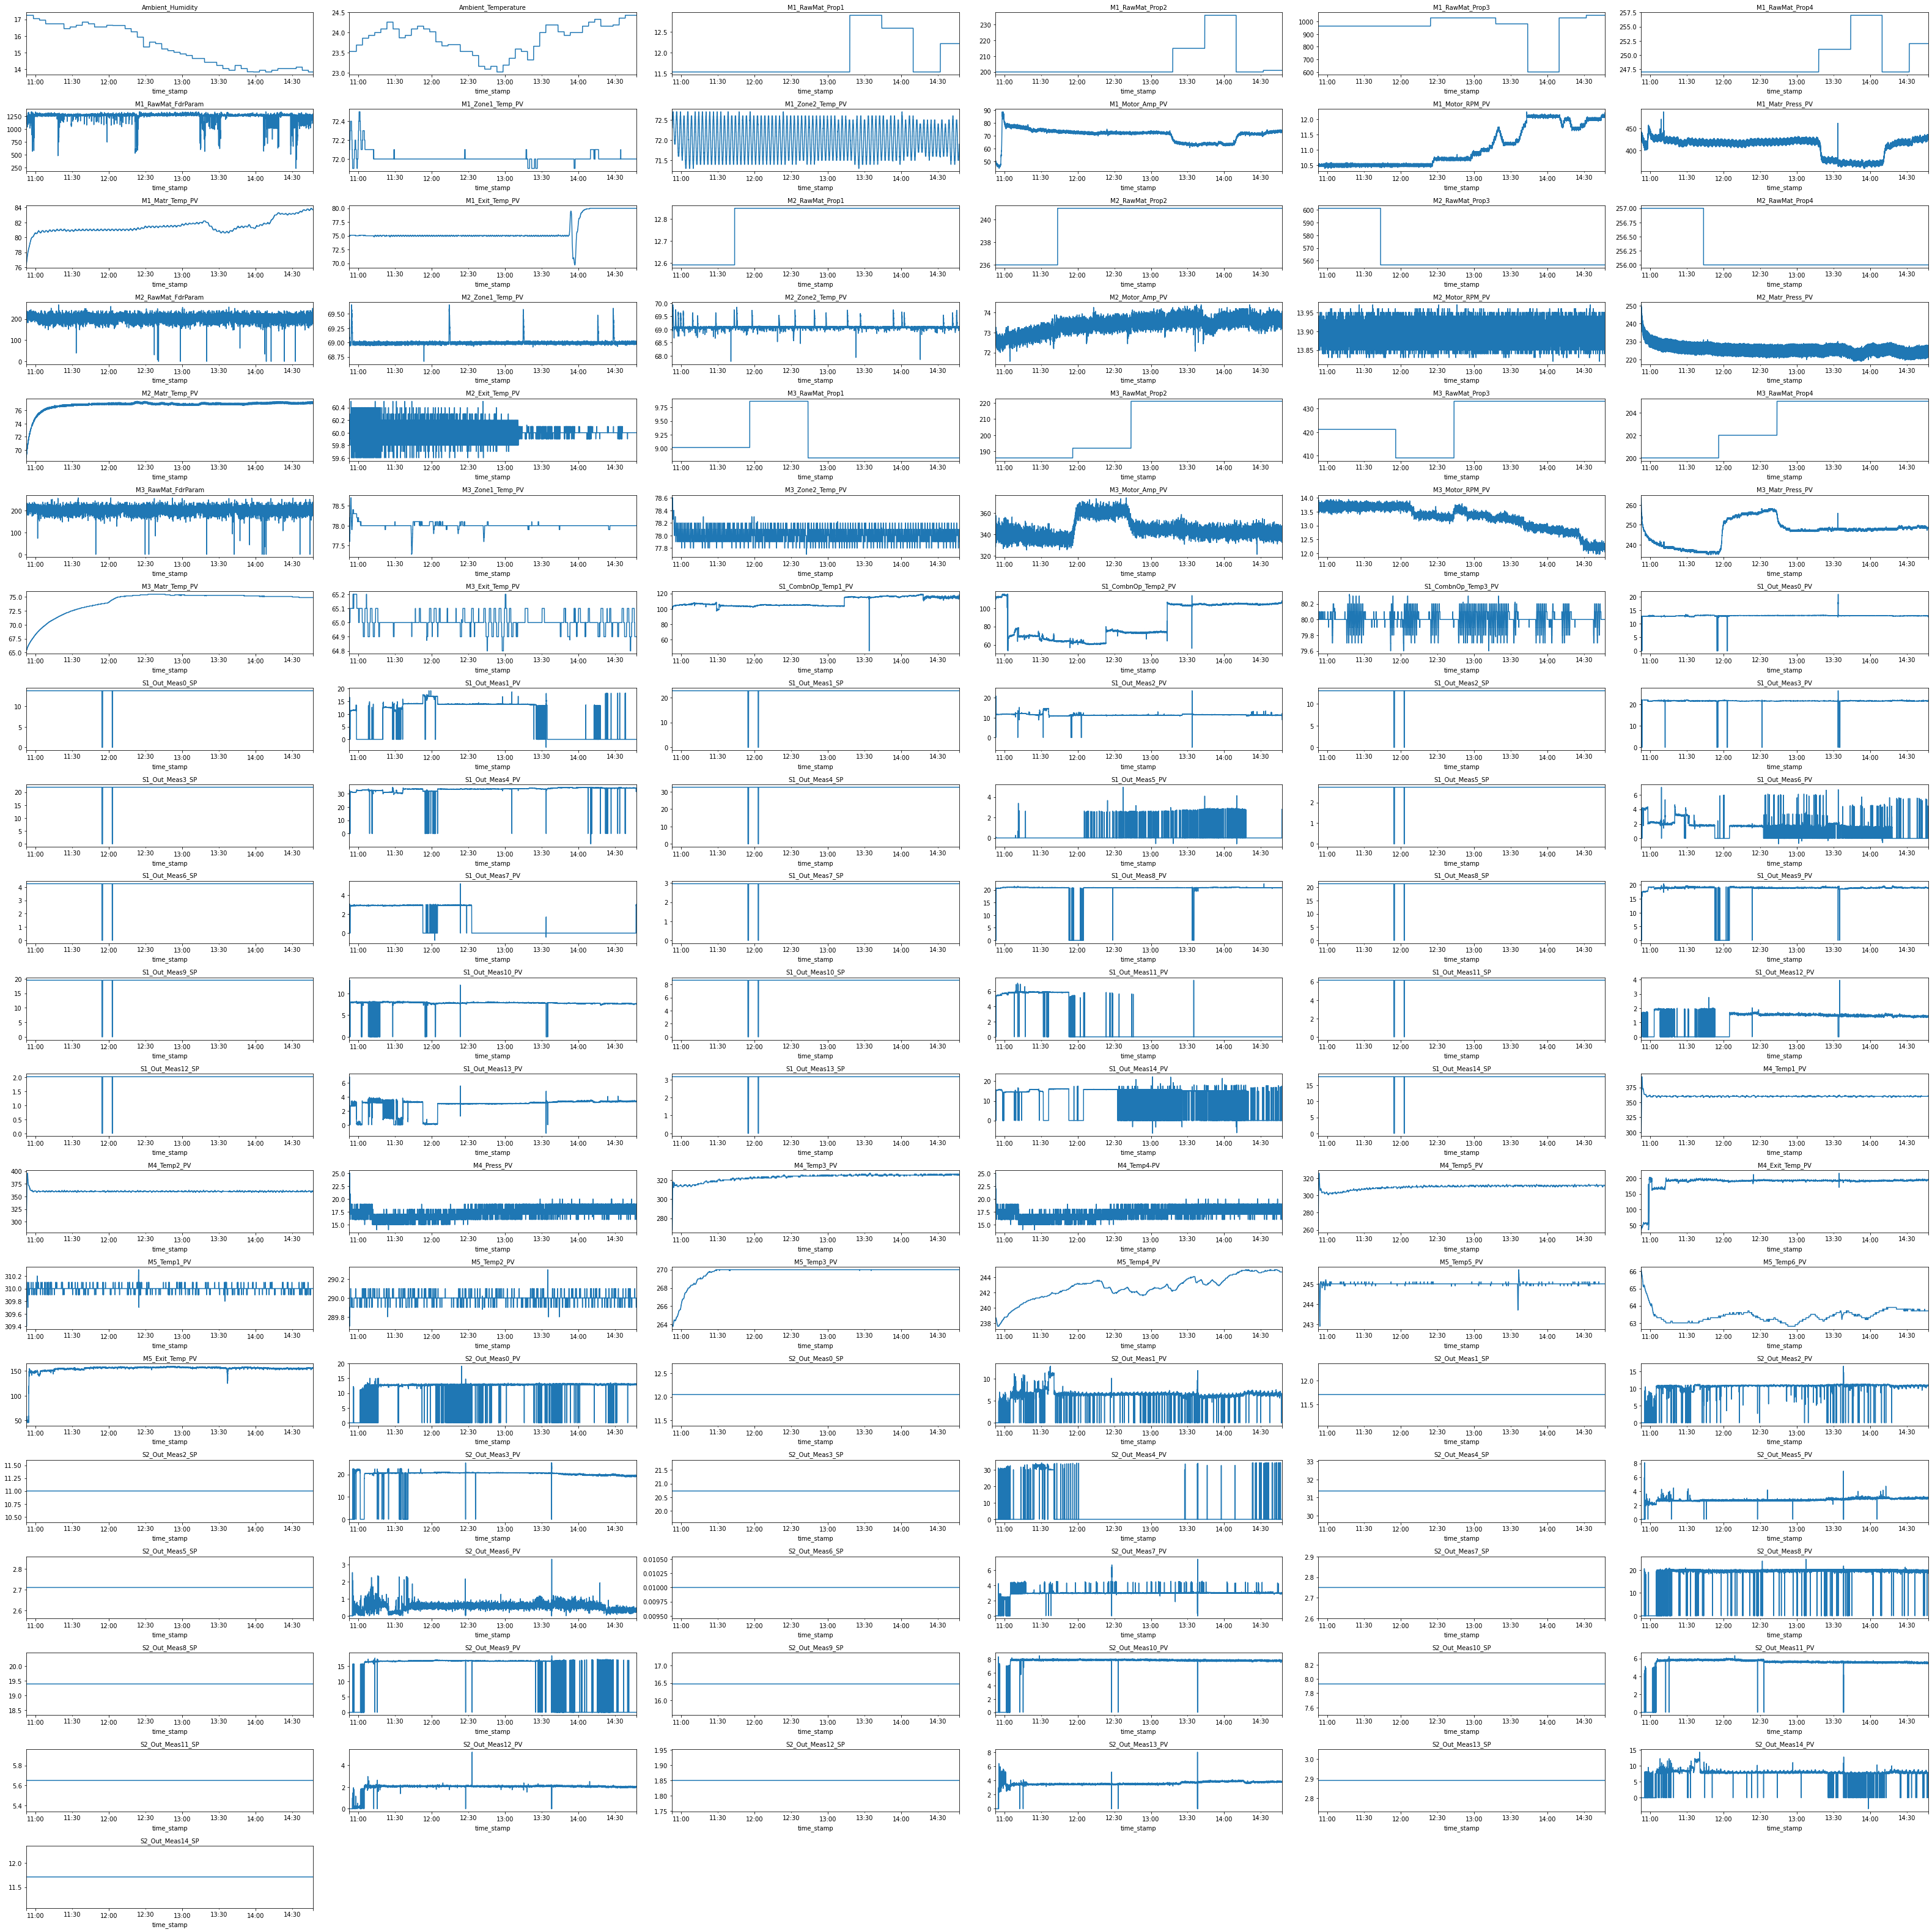

In [37]:
# Generate Plots for all columns
gspec=gridspec.GridSpec(20,6)
fig=plt.figure()
fig.set_size_inches([44,44])
count=0
for i in range(0,20):
    for j in range(0,6):
        count+=1
        if count>115:
            break
        thisplot=plt.subplot(gspec[i,j])
        df[df.columns[count-1]].plot()
        thisplot.figure.set_size_inches([44,44])
        thisplot.figure.tight_layout(h_pad=1.0)
        thisplot.set_title(f"{df.columns[count-1]}",fontsize=10)
        thisplot.tick_params(axis='y', labelsize=10)
        thisplot.tick_params(axis='x', labelsize=10)   

In [9]:
#Next:
#     - Investigate which columns are integers (suspect the SP's), and if they should be converted to floats
#     - Generate plots

